In [ ]:
import cv2
import numpy as np
import os


# unput and output paths
input_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Raw_image"
output_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\retinex_hist"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def single_scale_retinex(img, sigma):
    """Apply Single Scale Retinex on an image."""
    blur = cv2.GaussianBlur(img, (0, 0), sigma)
    retinex = np.log1p(img) - np.log1p(blur)
    return retinex

def multi_scale_retinex(img, sigmas=[15, 80, 250]):
    """Apply Multi-Scale Retinex on an image."""
    retinex = np.zeros_like(img, dtype=np.float32)
    for sigma in sigmas:
        retinex += single_scale_retinex(img, sigma)
    retinex = retinex / len(sigmas)
    return retinex

def apply_clahe(img):
    """Apply CLAHE to enhance contrast and reduce glare."""
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

# Apply Retinex and CLAHE to preprocess all the images in dataset
def apply_retinex_to_dataset(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Image not found: {filename}")
            continue

        img = img.astype(np.float32) / 255.0

        clahe_result = apply_clahe((img * 255).astype(np.uint8))

        msr_result = multi_scale_retinex(img)
        msr_result = cv2.normalize(msr_result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        combined_result = cv2.addWeighted(clahe_result, 0.7, msr_result, 0.3, 0)

        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, combined_result)
        print(f"Processed and saved: {filename}")

apply_retinex_to_dataset(input_folder, output_folder)


Processed and saved: NakedTop01.jpg
Processed and saved: NakedTop02.jpg
Processed and saved: NakedTop03.jpg
Processed and saved: NakedTop04.jpg
Processed and saved: NakedTop05.jpg
Processed and saved: NakedTop06.jpg
Processed and saved: NakedTop07.jpg
Processed and saved: NakedTop08.jpg
Processed and saved: NakedTop09.jpg
Processed and saved: NakedTop10.jpg
Processed and saved: NakedTop11.jpg
Processed and saved: NakedTop12.jpg
Processed and saved: NakedTop13.jpg
Processed and saved: NakedTop14.jpg
Processed and saved: NakedTop15.jpg
Processed and saved: NakedTop16.jpg
Processed and saved: NakedTop17.jpg
Processed and saved: NakedTop18.jpg
Processed and saved: NakedTop19.jpg
Processed and saved: NakedTop20.jpg


In [ ]:
import cv2
import numpy as np
import os

# input and output paths
input_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\retinex_hist"
output_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\denoise"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#Apply gaussian blur to all the images
def apply_gaussian_to_dataset(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Image not found: {filename}")
            continue

        gaussian_result = cv2.GaussianBlur(img, ksize=(5, 5), sigmaX=0.5)

        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, gaussian_result)
        print(f"Gaussian filter applied and saved: {filename}")


In [ ]:
apply_gaussian_to_dataset(input_folder, output_folder)

Gaussian filter applied and saved: NakedTop01.jpg
Gaussian filter applied and saved: NakedTop02.jpg
Gaussian filter applied and saved: NakedTop03.jpg
Gaussian filter applied and saved: NakedTop04.jpg
Gaussian filter applied and saved: NakedTop05.jpg
Gaussian filter applied and saved: NakedTop06.jpg
Gaussian filter applied and saved: NakedTop07.jpg
Gaussian filter applied and saved: NakedTop08.jpg
Gaussian filter applied and saved: NakedTop09.jpg
Gaussian filter applied and saved: NakedTop10.jpg
Gaussian filter applied and saved: NakedTop11.jpg
Gaussian filter applied and saved: NakedTop12.jpg
Gaussian filter applied and saved: NakedTop13.jpg
Gaussian filter applied and saved: NakedTop14.jpg
Gaussian filter applied and saved: NakedTop15.jpg
Gaussian filter applied and saved: NakedTop16.jpg
Gaussian filter applied and saved: NakedTop17.jpg
Gaussian filter applied and saved: NakedTop18.jpg
Gaussian filter applied and saved: NakedTop19.jpg
Gaussian filter applied and saved: NakedTop20.jpg


In [ ]:
import cv2
import numpy as np
import os

#input and output folder paths
input_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\denoise"
output_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\segmented_1311"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def check_aspect_ratio_angle_and_area(component_mask, min_area=3000, max_area=15000):
    """Check if the component has the correct aspect ratio, angles, and area."""

    x, y, w, h = cv2.boundingRect(component_mask) #bounding rectangle around the component

    aspect_ratio = w / float(h)  #aspect ratio of the component
    if not (0.8 < aspect_ratio < 1.2):
        return False

    area = w * h #area of the bounding rectangle
    if not (min_area <= area <= max_area):
        return False

    pts = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], dtype=np.float32)

    angles_ok = True #Checking corner angles to ensure the component is square
    for i in range(4):
        pt1, pt2, pt3, pt4 = pts[i], pts[(i + 1) % 4], pts[(i + 2) % 4], pts[(i + 3) % 4]
        #Calculate vectors and the angle
        vector1 = pt2 - pt1
        vector2 = pt3 - pt2

        angle = np.arccos(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))
        angle_degrees = np.degrees(angle)

        if not (80 < angle_degrees < 100):
            angles_ok = False
            break

    return angles_ok

def find_connected_components(img):
    """Identify connected components and draw boundaries around them."""

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #gray scale

    blurred = cv2.GaussianBlur(gray, (5, 5), 15) #Gaussian blur

    edges = cv2.Canny(blurred, 100, 200)   #Canny edge detection

    dilated = cv2.dilate(edges, None, iterations=2) #Dilate edges to close gaps

    num_labels, labels = cv2.connectedComponents(dilated)

    output_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR) # Gray scale image to BGR

    square_count = 0
    for label in range(1, num_labels):

        component_mask = np.zeros_like(gray)
        component_mask[labels == label] = 255

        if check_aspect_ratio_angle_and_area(component_mask):

            x, y, w, h = cv2.boundingRect(component_mask)  #bounding rectangle around the valid component

            cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            square_count += 1

        if square_count >= 27:
            break

    return output_img
#process the images to identify and segment components
def apply_segmentation_to_connected_components(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Image not found: {filename}")
            continue

        segmented_img = find_connected_components(img)

        output_path = os.path.join(output_folder, filename) # Save the segmented image
        cv2.imwrite(output_path, segmented_img)
        print(f"Segmented and saved: {filename}")


apply_segmentation_to_connected_components(input_folder, output_folder)


Segmented and saved: NakedTop01.jpg
Segmented and saved: NakedTop02.jpg
Segmented and saved: NakedTop03.jpg
Segmented and saved: NakedTop04.jpg
Segmented and saved: NakedTop05.jpg
Segmented and saved: NakedTop06.jpg
Segmented and saved: NakedTop07.jpg
Segmented and saved: NakedTop08.jpg
Segmented and saved: NakedTop09.jpg
Segmented and saved: NakedTop10.jpg
Segmented and saved: NakedTop11.jpg
Segmented and saved: NakedTop12.jpg
Segmented and saved: NakedTop13.jpg
Segmented and saved: NakedTop14.jpg
Segmented and saved: NakedTop15.jpg
Segmented and saved: NakedTop16.jpg
Segmented and saved: NakedTop17.jpg
Segmented and saved: NakedTop18.jpg
Segmented and saved: NakedTop19.jpg
Segmented and saved: NakedTop20.jpg


Mean IoU for NakedTop01.jpg: 0.561890376815934


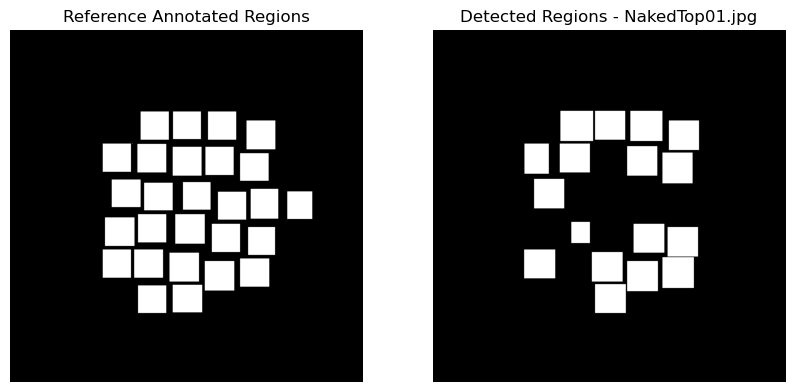

Mean IoU for NakedTop02.jpg: 0.6919697526947342


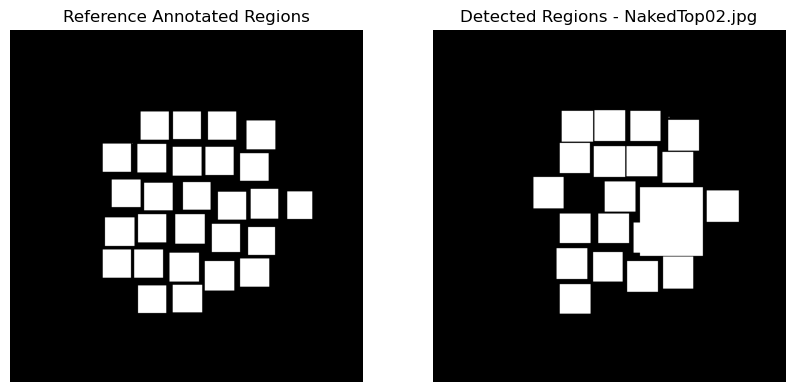

Mean IoU for NakedTop03.jpg: 0.5797987148846787


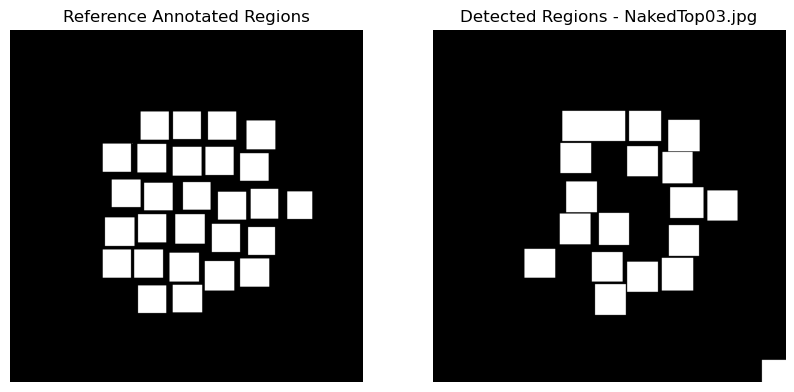

Mean IoU for NakedTop04.jpg: 0.6631317707950658


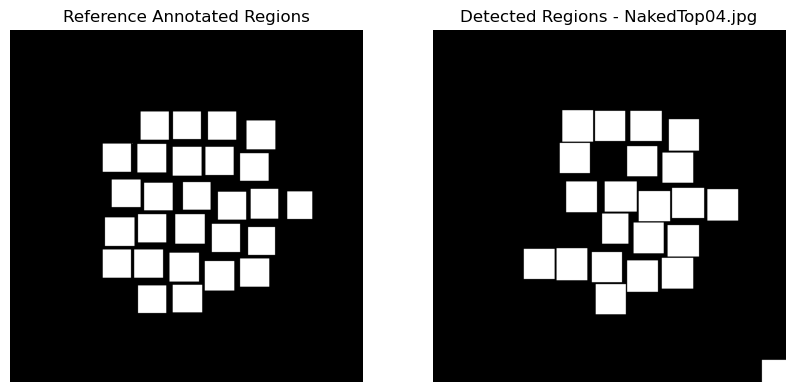

Mean IoU for NakedTop05.jpg: 0.8296601717864928


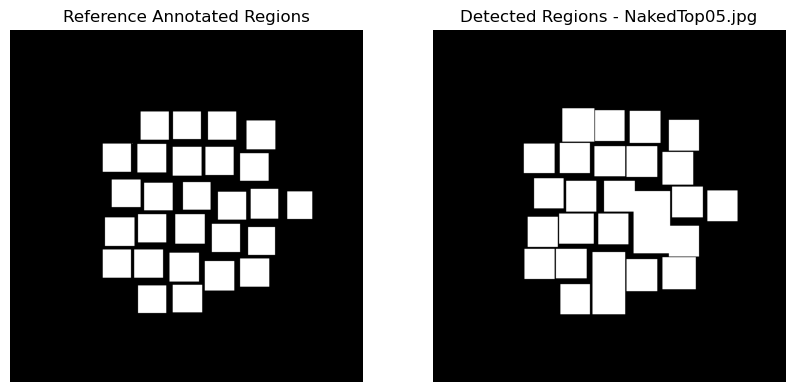

Mean IoU for NakedTop06.jpg: 0.7594791780855288


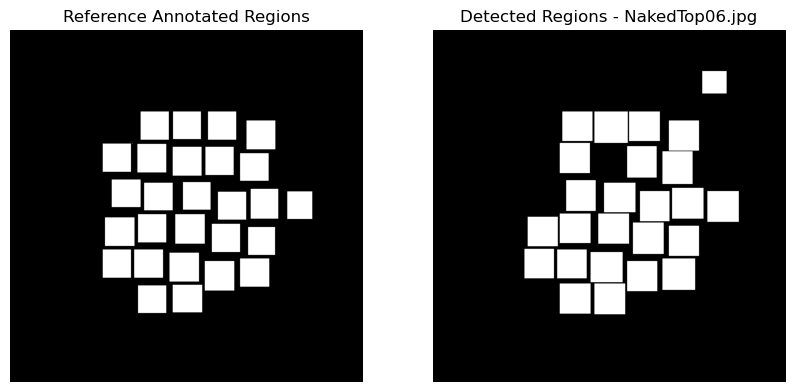

Mean IoU for NakedTop07.jpg: 0.7771037735147318


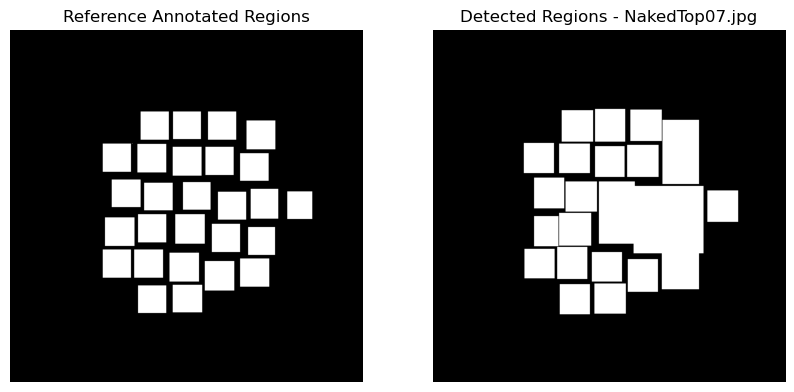

Mean IoU for NakedTop08.jpg: 0.7845086911351972


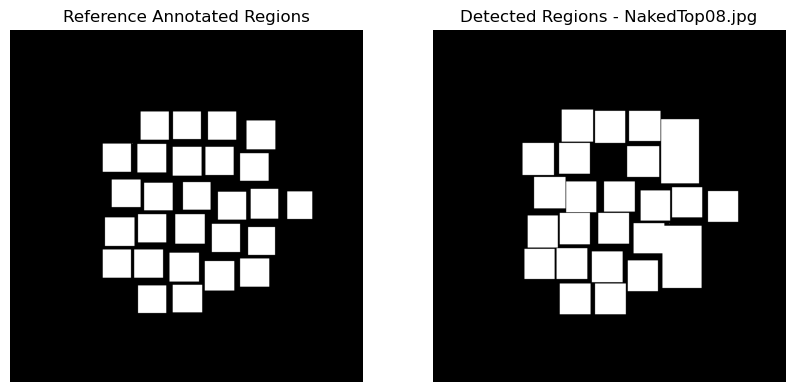

Mean IoU for NakedTop09.jpg: 0.6416913422191504


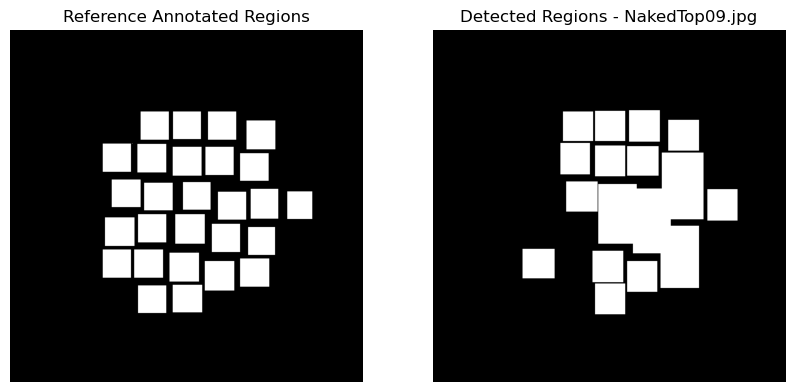

Mean IoU for NakedTop10.jpg: 0.8521804566032698


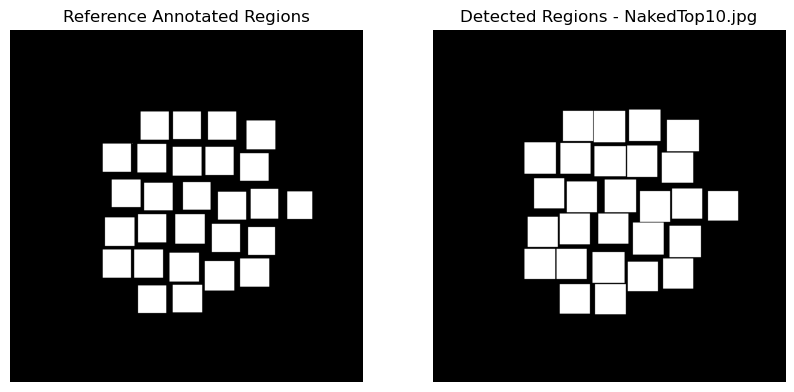

Mean IoU for NakedTop11.jpg: 0.7492885390102376


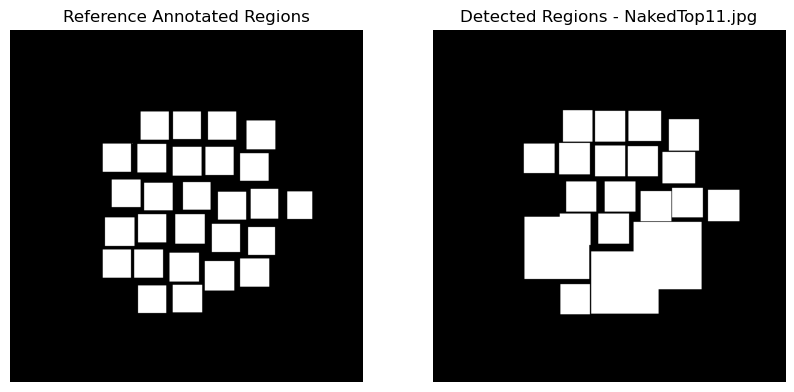

Mean IoU for NakedTop12.jpg: 0.6426460192721876


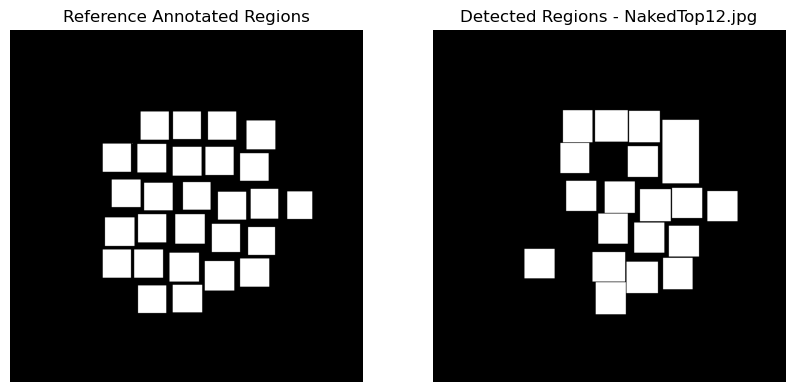

Mean IoU for NakedTop13.jpg: 0.7755154461321413


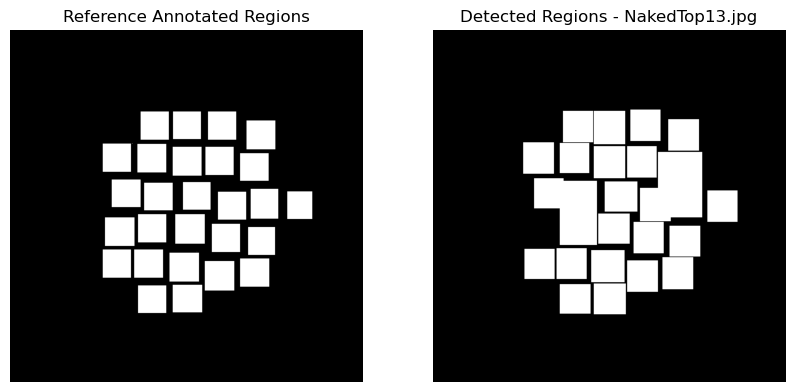

Mean IoU for NakedTop14.jpg: 0.7245691245976975


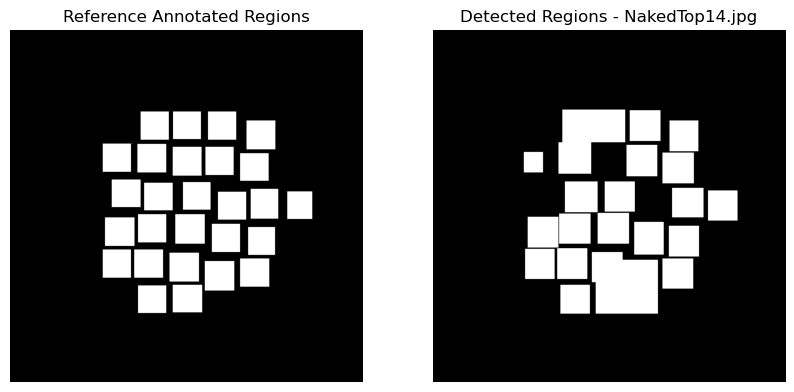

Mean IoU for NakedTop15.jpg: 0.7870508355868563


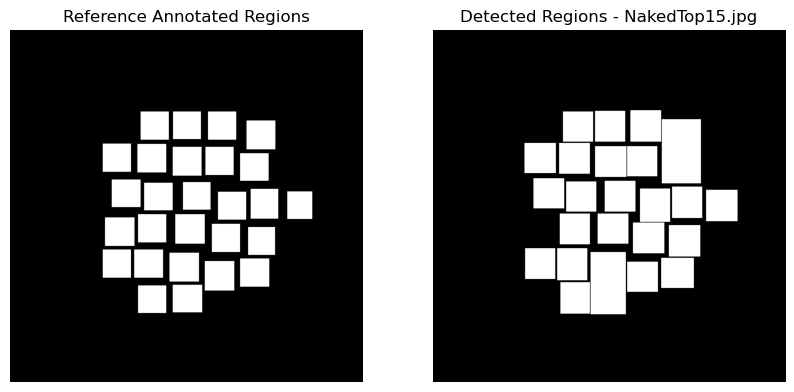

Mean IoU for NakedTop16.jpg: 0.8379959868471117


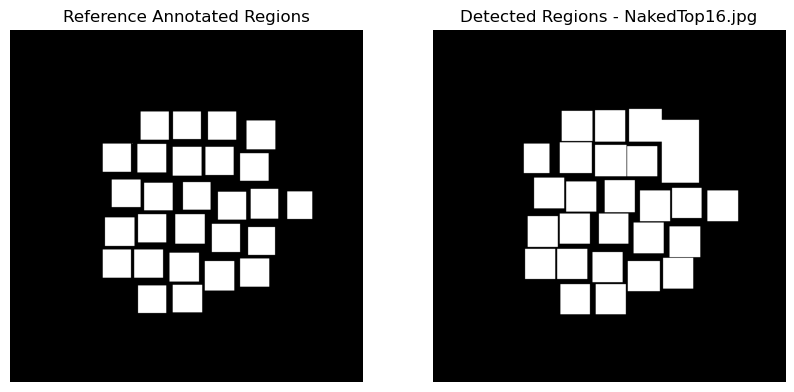

Mean IoU for NakedTop17.jpg: 0.6939623612292957


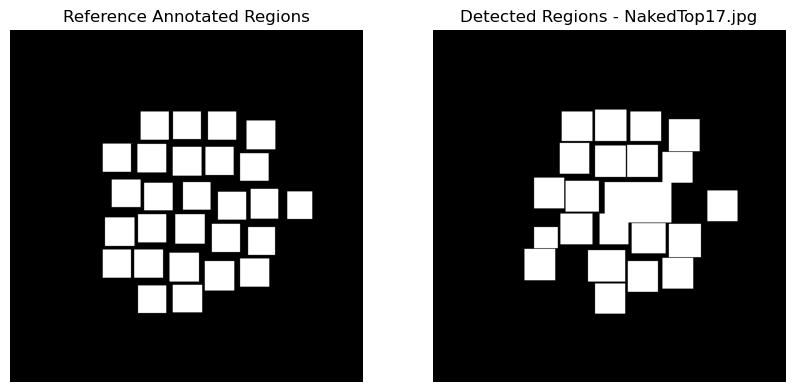

Mean IoU for NakedTop18.jpg: 0.7766133353747225


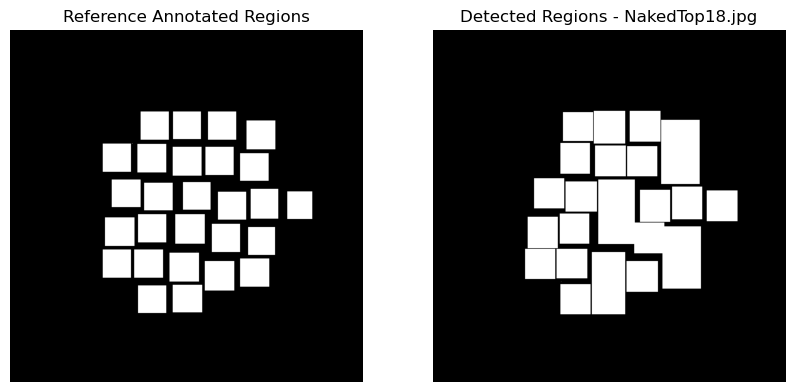

Mean IoU for NakedTop19.jpg: 0.8106002243307002


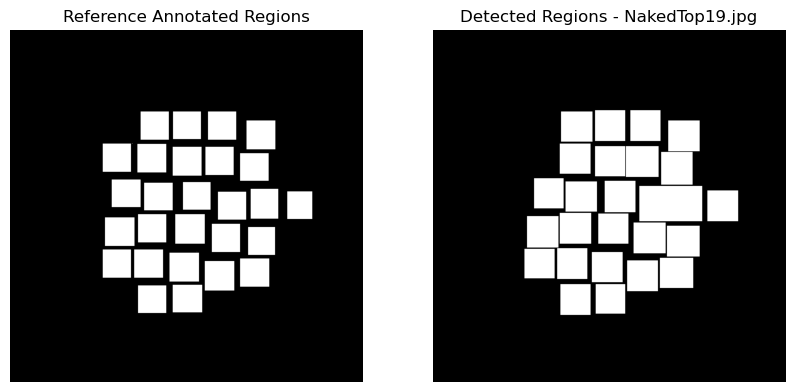

Mean IoU for NakedTop20.jpg: 0.67401412630346


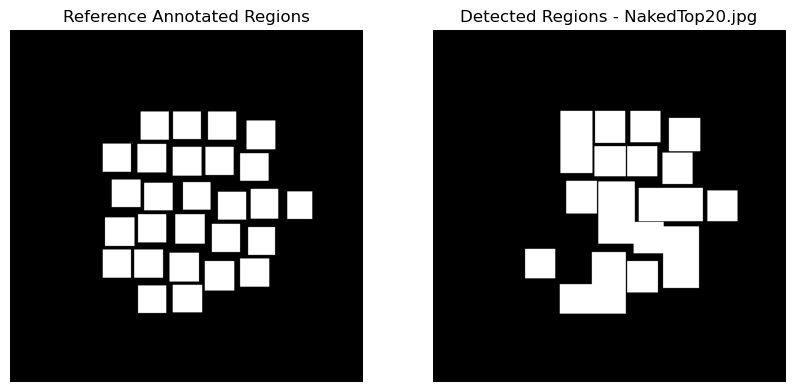

Overall Mean IoU for all images: 0.7306835113609598


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

detected_images = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\segmented_1311"
annotated_images = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\ann"

def calculate_combined_miou(annotated_bboxes, detected_bboxes, image_shape):
    """Calculate IoU for combined bounding box regions and return masks for visualization."""
    annotated_mask = np.zeros(image_shape, dtype=np.uint8)
    detected_mask = np.zeros(image_shape, dtype=np.uint8)

    for (x, y, w, h) in annotated_bboxes:
        annotated_mask[y:y+h, x:x+w] = 1

    for (x, y, w, h) in detected_bboxes:
        detected_mask[y:y+h, x:x+w] = 1

    intersection = np.logical_and(annotated_mask, detected_mask).sum()
    union = np.logical_or(annotated_mask, detected_mask).sum()

    miou = intersection / union if union != 0 else 1
    return miou, annotated_mask, detected_mask

def find_bounding_boxes(image, color_range):
    """Find bounding boxes in the image based on color range."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, color_range[0], color_range[1])
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [cv2.boundingRect(contour) for contour in contours]

#Display annotated and detected masks side by side.
def display_masks(annotated_mask, detected_mask, filename):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(annotated_mask, cmap='gray')
    axes[0].set_title("Reference Annotated Regions")
    axes[0].axis('off')

    axes[1].imshow(detected_mask, cmap='gray')
    axes[1].set_title(f"Detected Regions - {filename}")
    axes[1].axis('off')

    plt.show()

#Calculate Mean IoU for all detected images
def calculate_miou_for_all_images(detected_images_folder, annotated_image_path):
    results = {}
    miou_values = []
    green_color_range = (np.array([35, 50, 50]), np.array([85, 255, 255]))

    annotated_image = cv2.imread(annotated_image_path) # annotated reference path
    if annotated_image is None:
        print("Error loading the annotated image.")
        return results

    image_shape = annotated_image.shape[:2]
    annotated_bboxes = find_bounding_boxes(annotated_image, green_color_range) ## Find bounding boxes in the annotated image

    for filename in os.listdir(detected_images_folder):
        detected_image_path = os.path.join(detected_images_folder, filename)

        detected_image = cv2.imread(detected_image_path)
        if detected_image is None:
            print(f"Error loading detected image {filename}")
            continue

        detected_bboxes = find_bounding_boxes(detected_image, green_color_range) # Find bounding boxes in the detected image

        miou, annotated_mask, detected_mask =
        +(annotated_bboxes, detected_bboxes, image_shape)
        results[filename] = miou
        miou_values.append(miou)

        print(f"Mean IoU for {filename}: {miou}")
        display_masks(annotated_mask, detected_mask, filename)

    overall_mean_miou = np.mean(miou_values) if miou_values else 0 # Calculate overall mean IoU
    print(f"Overall Mean IoU for all images: {overall_mean_miou}")

    return results, overall_mean_miou

single_annotated_image = os.path.join(annotated_images, "annotated_reference.jpg")

miou_results, overall_mean_miou = calculate_miou_for_all_images(detected_images, single_annotated_image) ## Calculate IoU for all detected images


In [ ]:
import pandas as pd
miou_df = pd.DataFrame(list(miou_results.items()), columns=["Image", "mIoU"]) # Convert the dictionary of mIoU results into a pandas DataFrame

print("\nMean IoU for all images:")
miou_df


Mean IoU for all images:


,Image,mIoU
0,NakedTop01.jpg,0.561890
1,NakedTop02.jpg,0.691970
2,NakedTop03.jpg,0.579799
3,NakedTop04.jpg,0.663132
4,NakedTop05.jpg,0.829660
5,NakedTop06.jpg,0.759479
6,NakedTop07.jpg,0.777104
7,NakedTop08.jpg,0.784509
8,NakedTop09.jpg,0.641691
9,NakedTop10.jpg,0.852180


In [ ]:
print(f"Overall Mean IoU: {overall_mean_miou}")

Overall Mean IoU: 0.7306835113609598


In [ ]:
import cv2
import numpy as np
import os

input_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\denoise"
output_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\segmented_squares"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
#Check if the component has the correct aspect ratio, angles, and area.
def check_aspect_ratio_angle_and_area(component_mask, min_area=3000, max_area=15000):

    x, y, w, h = cv2.boundingRect(component_mask)
    aspect_ratio = w / float(h)
    if not (0.8 < aspect_ratio < 1.2):
        return False

    area = w * h
    if not (min_area <= area <= max_area):
        return False

    pts = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], dtype=np.float32)
    angles_ok = True
    for i in range(4):
        pt1, pt2, pt3, pt4 = pts[i], pts[(i + 1) % 4], pts[(i + 2) % 4], pts[(i + 3) % 4]
        vector1 = pt2 - pt1
        vector2 = pt3 - pt2
        angle = np.arccos(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))
        angle_degrees = np.degrees(angle)
        if not (80 < angle_degrees < 100):  # Allow some deviation
            angles_ok = False
            break
    return angles_ok

#Save all valid squares from an image to a single folder.
def save_individual_squares(img, labels, output_folder, file_prefix):
    square_count = 0
    for label in range(1, labels.max() + 1):
        component_mask = np.zeros_like(img[:, :, 0])
        component_mask[labels == label] = 255
        if check_aspect_ratio_angle_and_area(component_mask):
            x, y, w, h = cv2.boundingRect(component_mask)
            cropped_img = img[y:y + h, x:x + w]
            square_path = os.path.join(output_folder, f"{file_prefix}_square_{square_count + 1}.png")
            cv2.imwrite(square_path, cropped_img)
            square_count += 1
    print(f"Saved {square_count} squares for {file_prefix}.")

#segment connected components and save individual squares.
def apply_segmentation_and_save_squares(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image not found: {filename}")
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 15)
        edges = cv2.Canny(blurred, 100, 200)
        dilated = cv2.dilate(edges, None, iterations=2)
        num_labels, labels = cv2.connectedComponents(dilated)
        save_individual_squares(img, labels, output_folder, os.path.splitext(filename)[0])

apply_segmentation_and_save_squares(input_folder, output_folder)

Saved 17 squares for NakedTop01.
Saved 22 squares for NakedTop02.
Saved 19 squares for NakedTop03.
Saved 22 squares for NakedTop04.
Saved 28 squares for NakedTop05.
Saved 25 squares for NakedTop06.
Saved 27 squares for NakedTop07.
Saved 26 squares for NakedTop08.
Saved 21 squares for NakedTop09.
Saved 27 squares for NakedTop10.
Saved 26 squares for NakedTop11.
Saved 20 squares for NakedTop12.
Saved 26 squares for NakedTop13.
Saved 24 squares for NakedTop14.
Saved 26 squares for NakedTop15.
Saved 27 squares for NakedTop16.
Saved 23 squares for NakedTop17.
Saved 26 squares for NakedTop18.
Saved 26 squares for NakedTop19.
Saved 22 squares for NakedTop20.


In [ ]:
import os
from PIL import Image
import numpy as np

#dataset Path
dataset_path = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\Dataset"

images = []
labels = []

image_size = (100, 100)

#loop to label good or bad images
for label in ['good', 'bad']:
    folder_path = os.path.join(dataset_path, label)

    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)

            image = Image.open(img_path).convert('L')

            image = image.resize(image_size)

            image_array = np.array(image)

            images.append(image_array)
            labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [ ]:
images.shape

(475, 100, 100)

In [ ]:
labels.shape

(475,)

In [ ]:
import random
from PIL import Image, ImageEnhance
import numpy as np

image_size = (100, 100) # size of image

#Augument the images
def augment_image(image):
    image = image.rotate(270)

    #brightness enhancement
    if random.random() < 0.5:
        enhancer = ImageEnhance.Brightness(image)
        factor = random.uniform(0.5, 1.5)
        image = enhancer.enhance(factor)
    #contrast enhancement
    if random.random() < 0.5:
        enhancer = ImageEnhance.Contrast(image)
        factor = random.uniform(0.5, 1.5)
        image = enhancer.enhance(factor)

    image = image.resize(image_size)

    return image

augmented_images = list(images)
augmented_labels = list(labels)

for idx, img_array in enumerate(images):
    image = Image.fromarray(img_array)

    #augmentation with a 90% probability
    if random.random() < 0.9:
        augmented_image = augment_image(image)
        augmented_images.append(np.array(augmented_image))
        augmented_labels.append(labels[idx])

augmented_images = np.array([img.resize(image_size) if img.shape != image_size else img for img in augmented_images])
augmented_labels = np.array(augmented_labels)

In [ ]:
augmented_images.shape

(898, 100, 100)

In [ ]:
augmented_labels.shape

(898,)

In [ ]:
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# extract Local Binary Pattern (LBP) features from an image
def extract_lbp_features(image, P=8, R=1):

    lbp = local_binary_pattern(image, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)

    return lbp, hist

# LBP features for all augmented images
lbp_features = []
for image in augmented_images:
    _, lbp_feature = extract_lbp_features(image)
    lbp_features.append(lbp_feature)

#LBP features to array
X = np.array(lbp_features)
#Labels good or bad
y = np.array([1 if label == 'good' else 0 for label in augmented_labels])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#Support Vector Classifier with a linear kernel
svm = SVC(kernel='linear', random_state=42)

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
best_params = None

for train_idx, val_idx in cv.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred) # Calculate the accuracy of the model
    accuracies.append(accuracy)

    if best_params is None or accuracy > max(accuracies):
        best_params = svm.get_params()

best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

y_pred = best_svm.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred) # Calculate the accuracy of the best model

print(f"Best model's accuracy from cross-validation: {max(accuracies):.4f}")
print(f"Final model's accuracy on validation set: {final_accuracy:.4f}")


Best model's accuracy from cross-validation: 0.8252
Final model's accuracy on validation set: 0.7667


In [ ]:
best_params

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_svm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred) # confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[77 13]
 [29 61]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        90
           1       0.82      0.68      0.74        90

    accuracy                           0.77       180
   macro avg       0.78      0.77      0.76       180
weighted avg       0.78      0.77      0.76       180



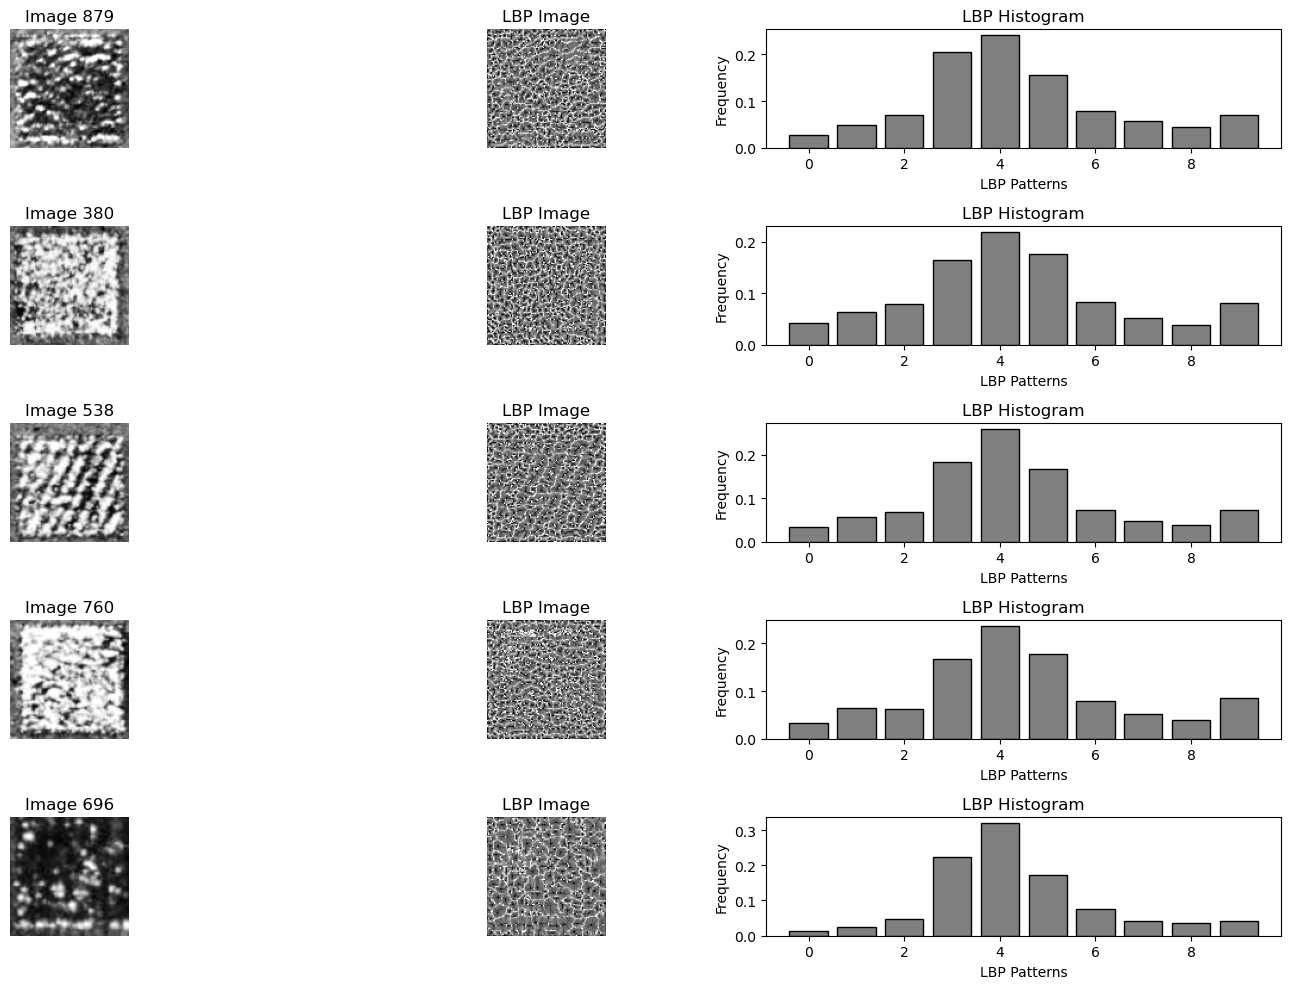

In [ ]:
np.random.seed()
random_indices = np.random.choice(len(augmented_images), 5, replace=False)
random_images = [augmented_images[idx] for idx in random_indices]

plt.figure(figsize=(15, 10))
# Loop for random image to display the original image, LBP image, and LBP histogram
for i, image in enumerate(random_images):
    lbp_image, lbp_histogram = extract_lbp_features(image)

    #Grayscale image
    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image {random_indices[i]}")
    plt.axis('off')

    #LBP image
    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(lbp_image, cmap='gray')
    plt.title("LBP Image")
    plt.axis('off')

    #histogram of LBP values
    plt.subplot(5, 3, i * 3 + 3)
    plt.bar(np.arange(len(lbp_histogram)), lbp_histogram, color='gray', edgecolor='black')
    plt.title("LBP Histogram")
    plt.xlabel("LBP Patterns")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# extract Local Binary Pattern (LBP)
def extract_lbp_features(image, P=8, R=1):
    if len(image.shape) == 2:
        gray_image = image
    elif len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Image must be either grayscale or color.")

    ## Compute LBP using the uniform method
    lbp = local_binary_pattern(gray_image, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2)) # histogram of LBP values
    hist = hist.astype('float') # Normalize the histogram to sum to 1
    hist /= (hist.sum() + 1e-6)
    return hist

lbp_features = [] # Extract LBP features from each augmented image
for image in augmented_images:
    lbp_feature = extract_lbp_features(image)
    lbp_features.append(lbp_feature)

X = np.array(lbp_features)
y = np.array([1 if label == 'good' else 0 for label in augmented_labels])

# Standardize the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
best_params = None

# Perform cross-validation
for train_idx, val_idx in cv.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    if best_params is None or accuracy > max(accuracies):
        best_params = xgb.get_params()

best_xgb = XGBClassifier(**best_params)
best_xgb.fit(X_train_val, y_train_val)

y_pred = best_xgb.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Best model's accuracy from cross-validation: {max(accuracies):.4f}")
print(f"Final model's accuracy on the test set: {final_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


C:\Users\keert\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\keert\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\keert\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\keert\anaconda3\lib\site-packages\

Best model's accuracy from cross-validation: 0.8699
Final model's accuracy on the test set: 0.8634

Confusion Matrix:
[[82  9]
 [16 76]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        91
           1       0.89      0.83      0.86        92

    accuracy                           0.86       183
   macro avg       0.87      0.86      0.86       183
weighted avg       0.87      0.86      0.86       183



In [ ]:
best_params

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

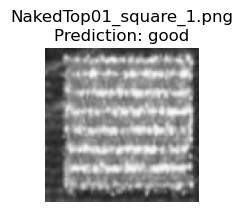

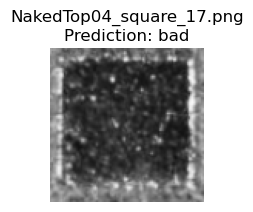

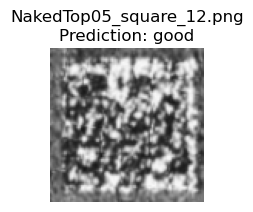

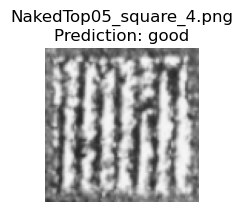

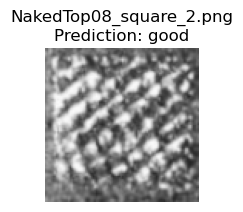

In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

unseen_images_path = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\Unseen"

unseen_images = []
image_names = []
for file_name in os.listdir(unseen_images_path):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(unseen_images_path, file_name)
        image = cv2.imread(img_path)
        resized_image = cv2.resize(image, (100, 100))
        unseen_images.append(resized_image)
        image_names.append(file_name)

# List to store LBP features
unseen_lbp_features = []
# Loop through each unseen image and extract its LBP features
for image in unseen_images:
    lbp_feature = extract_lbp_features(image)
    unseen_lbp_features.append(lbp_feature)

X_unseen = np.array(unseen_lbp_features) # Convert the list of LBP features

X_unseen_scaled = scaler.transform(X_unseen)

unseen_predictions = best_svm.predict(X_unseen_scaled)

predicted_labels = ['good' if label == 1 else 'bad' for label in unseen_predictions]

for image, image_name, prediction in zip(unseen_images, image_names, predicted_labels):
    plt.figure(figsize=(2, 2))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"{image_name}\nPrediction: {prediction}")
    plt.axis('off')
    plt.show()

In [ ]:
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#extract HOG features from images
def extract_hog_features(image, pixels_per_cell=(4, 4), cells_per_block=(3, 3), orientations=6):

    if len(image.shape) > 2:
        image = image[:, :, 0]
    hog_features = hog(image, pixels_per_cell=pixels_per_cell, # Extract HOG features with specified parameters
                       cells_per_block=cells_per_block,
                       orientations=orientations, block_norm='L2-Hys')
    return hog_features

# List to store HOG features
hog_features = []
# Loop Augumented images and extract HOG features
for image in augmented_images:
    hog_feature = extract_hog_features(image)
    hog_features.append(hog_feature)

X = np.array(hog_features) # Convert the list of HOG features into a numpy array
y = np.array([1 if label == 'good' else 0 for label in augmented_labels]) # Labels

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
best_params = None
# Perform cross-validation
for train_idx, val_idx in cv.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    if best_params is None or accuracy > max(accuracies):
        best_params = svm.get_params()

best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test) # Evaluate the model on the test set
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Best model's accuracy from cross-validation: {max(accuracies):.4f}")
print(f"Final model's accuracy on test set: {final_accuracy:.4f}")


Best model's accuracy from cross-validation: 0.7014
Final model's accuracy on test set: 0.6722


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_svm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred) # confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[60 30]
 [29 61]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        90
           1       0.67      0.68      0.67        90

    accuracy                           0.67       180
   macro avg       0.67      0.67      0.67       180
weighted avg       0.67      0.67      0.67       180



In [ ]:
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def extract_lbp_features(image, P=8, R=1):
    # Extract Local Binary Pattern (LBP) features from the image
    lbp = local_binary_pattern(image, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_hog_features(image, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9):
    # Extract Histogram of Oriented Gradients (HOG) features from the image
    if len(image.shape) > 2:
        image = image[:, :, 0]  # Convert to grayscale if the image is not already
    hog_features = hog(image, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       orientations=orientations, block_norm='L2-Hys')
    return hog_features

features = []
for image in augmented_images:
    # Extract LBP and HOG features and combine them
    lbp_feature = extract_lbp_features(image)
    hog_feature = extract_hog_features(image)
    combined_feature = np.concatenate((lbp_feature, hog_feature))
    features.append(combined_feature)

X = np.array(features)
y = np.array([1 if label == 'good' else 0 for label in augmented_labels])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize the feature matrix

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  # Split data into training/validation and test sets

svm = SVC(kernel='linear', random_state=42)  # Initialize Support Vector Machine (SVM)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Set up 5-fold cross-validation

accuracies = []
best_params = None

for train_idx, val_idx in cv.split(X_train_val, y_train_val):
    # Train and validate SVM model using cross-validation
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    svm.fit(X_train, y_train)  # Train SVM
    y_pred = svm.predict(X_val)  # Predict on validation set
    accuracy = accuracy_score(y_val, y_pred)  # Calculate accuracy
    accuracies.append(accuracy)

    if best_params is None or accuracy > max(accuracies):
        best_params = svm.get_params()  # Store best parameters

best_svm = SVC(**best_params)  # Initialize SVM with best parameters
best_svm.fit(X_train, y_train)  # Train the final model on the entire training set
y_pred = best_svm.predict(X_test)  # Predict on the test set
final_accuracy = accuracy_score(y_test, y_pred)  # Calculate final accuracy

# Print the results
print(f"Best model's accuracy from cross-validation: {max(accuracies):.4f}")
print(f"Final model's accuracy on test set: {final_accuracy:.4f}")


Best model's accuracy from cross-validation: 0.6853
Final model's accuracy on test set: 0.6889


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_svm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred) # confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[62 28]
 [28 62]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        90
           1       0.69      0.69      0.69        90

    accuracy                           0.69       180
   macro avg       0.69      0.69      0.69       180
weighted avg       0.69      0.69      0.69       180

